# Data preparation

Uncomment to create TH flickr8k dataset

In [ ]:
# from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
# import torch
# from datasets import load_dataset
# import random

# dataset = load_dataset("Naveengo/flickr8k", trust_remote_code=True)
# # Use NLLB to translate English to Thai
# model = AutoModelForSeq2SeqLM.from_pretrained("wtarit/nllb-600M-th-en")
# tokenizer = AutoTokenizer.from_pretrained("wtarit/nllb-600M-th-en")

# device = 0 if torch.cuda.is_available() else "cpu"
# translation_pipeline = pipeline(
#     "translation", 
#     model=model, 
#     tokenizer=tokenizer, 
#     src_lang="eng_Latn", 
#     tgt_lang="tha_Thai", 
#     max_length=400, 
#     device=device,
#     batch_size=8
# )

# def translate(text):
#     result = translation_pipeline(text)
#     return [res['translation_text'] for res in result]

# dataset = dataset.map(lambda x: {"image": x["image"], "text": translate(x['text'])}, batched=True, batch_size=8)


# idx = random.randint(0, len(dataset['train']))
# print(dataset['train'][idx]['text'])
# dataset['train'][idx]['image']
# dataset.push_to_hub("betteracs/flickr8k_th")

# Dataset & DataLoader

In [1]:
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset_name: str, processor, device):
        self.dataset = load_dataset(dataset_name, trust_remote_code=True)['train']
        self.processor = processor
        self.device = device

    def __len__(self):
        return len(self.dataset['text'])

    def __getitem__(self, idx):
        return {
            "feat": self.processor(images=self.dataset[idx]['image'], return_tensors="pt").to(self.device),
            "text": "รูปภาพของ " + self.dataset[idx]['text'],
        }


# Model

In [2]:
from transformers import AutoTokenizer, AutoImageProcessor, AutoModel, LlamaForCausalLM
import torch

processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
train_dataset = ImageCaptioningDataset("betteracs/flickr8k_th", processor=processor, device="cuda")
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

In [3]:
from transformers import AutoTokenizer, AutoModel, LlamaForCausalLM

class ImageCaptioningModel(torch.nn.Module):
    def __init__(self, image_model_name: str="facebook/dinov2-base", llm_model_name: str="meta-llama/Llama-3.2-1B", device="cuda"):
        super().__init__()
        
        self.dinov2 = AutoModel.from_pretrained(image_model_name).to(device)
        # Freeze the image model
        for param in self.dinov2.parameters():
            param.requires_grad = False
        self.dinov2.eval()

        self.llama_model = LlamaForCausalLM.from_pretrained(llm_model_name).to(device)
        self.tokenizer = AutoTokenizer.from_pretrained(llm_model_name)
        self.tokenizer.add_special_tokens({
            'pad_token': '[PAD]',
            'cls_token': '[CLS]'
        })
        self.llama_model.resize_token_embeddings(len(self.tokenizer))

        hidden_size = self.llama_model.config.hidden_size
        # No resize image. Just reduce the dimension from 257 to 1 (B, 257, 768) -> (B, 10, 768)
        self.conv1 = torch.nn.Conv1d(257, 10, 1).to(device)
        self.relu = torch.nn.ReLU()
        self.fc = torch.nn.Linear(768, hidden_size).to(device)

        self.device = device

    def generate(self, pixel_values, prompt):
        with torch.no_grad():
            image_features = self.dinov2(pixel_values).last_hidden_state # (B, 257, 768)
        
        image_features = self.conv1(image_features)
        image_features = self.relu(image_features)
        image_features = self.fc(image_features)

        input_ids = self.tokenizer(prompt, return_tensors="pt", padding=True, truncation=True, max_length=64).to(self.device)
        input_embeds = self.llama_model.model.embed_tokens(input_ids.input_ids).to(self.device) #self.llama_model(input_ids.) # (B, L, 768)
        print(len(input_ids.input_ids), input_ids)
        
        input_embeds = torch.cat([image_features, input_embeds], dim=1).to(self.device) # (B, L+10, 768)
        out = self.llama_model.generate(inputs_embeds=input_embeds, pad_token_id=self.tokenizer.pad_token_id, max_length=64, do_sample=True)
        return prompt + self.tokenizer.batch_decode(out, skip_special_tokens=True)

    def forward(self, pixel_values, text):
        with torch.no_grad():
            image_features = self.dinov2(pixel_values).last_hidden_state # (B, 257, 768)
        
        image_features = self.conv1(image_features)
        image_features = self.relu(image_features)
        image_features = self.fc(image_features)


        input_ids = self.tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=64).to(self.device)
        input_embeds = self.llama_model.model.embed_tokens(input_ids.input_ids).to(self.device) # (B, L, 768)

        offset = (torch.ones((image_features.shape[0], 10)) * self.tokenizer.cls_token_id).to(self.device)
        labels = torch.cat([offset, input_ids.input_ids], dim=1).long()

        input_embeds = torch.cat([image_features, input_embeds], dim=1).to(self.device)  # (B, L+10, hidden_size)
        output = self.llama_model(inputs_embeds=input_embeds, labels=labels)

        return output

# Train

In [4]:
model = ImageCaptioningModel()

print("Params: ", sum(p.numel() for p in model.parameters() if p.requires_grad))

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = Lion(model.parameters(), lr=1e-4, weight_decay=1e-2)

Params:  1237395988


In [6]:
from tqdm import tqdm

epochs = 6
batch_size = 2
num_steps = len(train_dataloader) * epochs

loss = 0
sample = ""
description = "Training.. loss: {loss}"

with tqdm(total=num_steps, desc=description.format(loss=0)) as pbar:
    for epoch in range(epochs):
        model.train()
        avg_loss = 0

        for batch_no, batch in enumerate(train_dataloader):
            optimizer.zero_grad()

            outputs = model(
              pixel_values=batch['feat'].pixel_values.squeeze(1),
              text=batch["text"]
            )
            outputs.loss.backward()

            avg_loss += outputs.loss.cpu().detach().numpy()
            loss = avg_loss / (batch_no + 1)
            pbar.set_description(description.format(loss=loss))

            optimizer.step()
            pbar.update(1)

        model.eval()
        for batch_no, batch in enumerate(train_dataloader):
            with torch.no_grad():
                outputs = model.generate(prompt=["รูปภาพของ "] * batch_size, pixel_values=batch["feat"].pixel_values.squeeze(1).to("cuda"))
            print(outputs)
            break

torch.save(model.state_dict(), "SimpleCaptioning.pt")

Training.. loss: 1.817424861613884:  17%|█▋        | 4046/24276 [59:53<5:10:34,  1.09it/s] 

2 {'input_ids': tensor([[128000,  23084, 105756, 102235, 100618,    220],
        [128000,  23084, 105756, 102235, 100618,    220]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1]], device='cuda:0')}
['รูปภาพของ ', 'รูปภาพของ ', '4 "2 "4 "5 "2 "4 "4 "4 " "2 " " " " " " "4 " " " " " " " " " "4 " " " " " " " " " " "', '4 หมาเล่นในหิมะ']


Training.. loss: 1.210570441607756:  33%|███▎      | 8092/24276 [1:59:54<3:52:56,  1.16it/s] 

2 {'input_ids': tensor([[128000,  23084, 105756, 102235, 100618,    220],
        [128000,  23084, 105756, 102235, 100618,    220]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1]], device='cuda:0')}
['รูปภาพของ ', 'รูปภาพของ ', '4 สุนัขน้ําตาล ที่ยืนอยู่บนพื้นที่ยืนอยู่ข้างหลังเขาแข็งที่ยืนอยู่บนสาย', '4 คนขี่เล่นบนหินสีฟ้า']


Training.. loss: 0.9792598536900082:  50%|█████     | 12138/24276 [2:59:50<3:02:21,  1.11it/s]

2 {'input_ids': tensor([[128000,  23084, 105756, 102235, 100618,    220],
        [128000,  23084, 105756, 102235, 100618,    220]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1]], device='cuda:0')}
['รูปภาพของ ', 'รูปภาพของ ', '5 คนบนจักรยานบินลงทางน้ําตก', '4 หมาขาวดําและหมาดําและขาวดําและขาวดําและขาวดําและขาวดําในหิมะ']


Training.. loss: 0.7635066412772303:  67%|██████▋   | 16184/24276 [3:59:43<1:58:15,  1.14it/s]

2 {'input_ids': tensor([[128000,  23084, 105756, 102235, 100618,    220],
        [128000,  23084, 105756, 102235, 100618,    220]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1]], device='cuda:0')}
['รูปภาพของ ', 'รูปภาพของ ', '5 สาวในสวมน้ําเดินตามสนามที่สนามกีฬา', '4 คน ที่ใส่เครื่องเล่นสีแดงอยู่ในปากของเขา ที่ใส่หมวก']


Training.. loss: 0.5797214551588951:  83%|████████▎ | 20230/24276 [4:59:28<56:40,  1.19it/s]   

2 {'input_ids': tensor([[128000,  23084, 105756, 102235, 100618,    220],
        [128000,  23084, 105756, 102235, 100618,    220]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1]], device='cuda:0')}
['รูปภาพของ ', 'รูปภาพของ ', '4 เด็กชายวิ่งบนถนนป่าใกล้น้ํา', 'เด็กชายเล่นบนสนามเล็กๆ ที่มีเท้าบน swing']


Training.. loss: 0.33913390515570113: 100%|██████████| 24276/24276 [5:59:06<00:00,  1.16it/s]  

2 {'input_ids': tensor([[128000,  23084, 105756, 102235, 100618,    220],
        [128000,  23084, 105756, 102235, 100618,    220]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1]], device='cuda:0')}


Training.. loss: 0.33913390515570113: 100%|██████████| 24276/24276 [5:59:08<00:00,  1.13it/s]

['รูปภาพของ ', 'รูปภาพของ ', '4 คนในเสื้อสีชมพู กําลังเล่นเกะบอร์ดในหิมะและพื้นฐานในพื้นฐาน', '5 เด็กเล่นในน้ําตาลหน้าอาคาร']


# Model evaluation

In [14]:
import gdown
url = 'https://drive.google.com/uc?id=1hXwWeFZvTn3tB5pBRayDbavxHCKH2DBt'
gdown.download(url, 'SimpleCaptioning.pt', quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1hXwWeFZvTn3tB5pBRayDbavxHCKH2DBt
From (redirected): https://drive.google.com/uc?id=1hXwWeFZvTn3tB5pBRayDbavxHCKH2DBt&confirm=t&uuid=70ad1bb5-3b11-4914-bcb6-e1ab9edf62e5
To: /home/monsh/works/SimpleCaptioning/SimpleCaptioning.pt
100%|██████████| 5.30G/5.30G [02:52<00:00, 30.6MB/s]


'SimpleCaptioning.pt'

In [15]:
model = ImageCaptioningModel()
model.load_state_dict(torch.load('./SimpleCaptioning.pt', weights_only=True))

<All keys matched successfully>

1 {'input_ids': tensor([[128000,  23084, 105756, 102235, 100618]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1]], device='cuda:0')}
['รูปภาพของ', ' มีคนกําลังสโนว์บอร์ดเหนือโครงสร้างหิมะ']


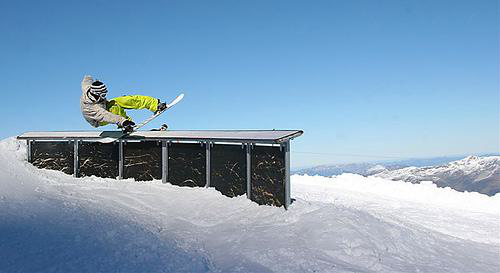

In [18]:
import random

random_idx = random.randint(0, len(train_dataset.dataset))
for i, data in enumerate(train_dataset.dataset):
    if i < random_idx:
        continue

    with torch.no_grad():
        imgs = processor(images=data['image'], return_tensors="pt")
        print(model.generate(imgs['pixel_values'].to("cuda"), ["รูปภาพของ"]))
    break

data['image']